# Homework 3
Marco Boscato - 2096921

## NUMERICALLY SOLVING A GRAVITATIONAL PROBLEM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

Article IC

In [2]:
# IC 
mass = 1.5*1e10                                 # kg
G = 6.67*1e-11                                  # m^3 kg^-1 s^-2
pos = np.array([[-10., -0.5], [10., 0.5]])      # m
vel = np.array([[1., 0.], [-1., 0.]])           # m/s
Gm = 1.0                                        # m^3 s^-2

In [3]:
def acceleration(r):
    r1, r2 = r[:2], r[2:]
    r12 = r2 - r1
    r21 = r1 - r2
    a1 = Gm * r12 / np.linalg.norm(r12)**3
    a2 = Gm * r21 / np.linalg.norm(r21)**3
    return np.array([a1, a2]).flatten()

In [4]:
def energy(x, v, m):
    r1, r2 = x[:2], x[2:]
    v1, v2 = v[:2], v[2:]
    r12 = r2 - r1
    return 0.5*m*(np.linalg.norm(v1)**2 + np.linalg.norm(v2)**2) - (G*m**2.)/(np.linalg.norm(r12))

In [5]:
def Euler_method(x, v, t):
    r = x + v*t
    a = acceleration(x)
    v = v + a*t
    return r, v

In [6]:
def Euler_integrator(x, v, max_iter, tol, h):
    t = 0.
    x_list = [x]
    v_list = [v]
    energy_list = [energy(x, v, mass)]
    time_list = [t]

    x_new, v_new = Euler_method(x, v, h)
    x_list.append(x_new)
    v_list.append(v_new)
    energy_list.append(energy(x_new, v_new, mass))
    time_list.append(t + h)

    iter = 0

    while (np.linalg.norm(x_list[-1] - x_list[-2]) > tol and iter<=max_iter):
        x_new, v_new = Euler_method(x_list[-1], v_list[-1], h)
        x_list.append(x_new)
        v_list.append(v_new)
        energy_list.append(energy(x_new, v_new, mass))
        time_list.append(time_list[-1] + h)
        iter += 1
    return np.array(x_list), np.array(v_list), np.array(energy_list), np.array(time_list)

In [7]:
integrated_pos, integrated_vel, system_energy, time = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, 1e-1)

# with larger time step
integrated_pos_2, integrated_vel_2, system_energy_2, time_2 = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, 5e-1)

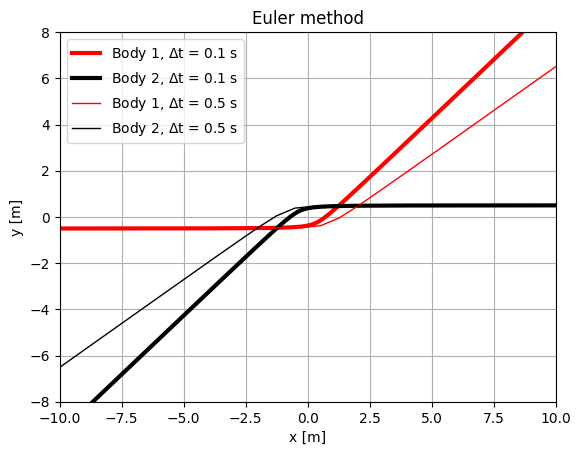

In [8]:
# plot the results
plt.figure()
plt.title('Euler method')
plt.plot(integrated_pos[:,0], integrated_pos[:,1], 'r', label='Body 1, $\Delta$t = 0.1 s', linewidth=3)
plt.plot(integrated_pos[:,2], integrated_pos[:,3], 'black', label='Body 2, $\Delta$t = 0.1 s', linewidth=3)
plt.plot(integrated_pos_2[:,0], integrated_pos_2[:,1], 'r', label='Body 1, $\Delta$t = 0.5 s', linewidth=1)
plt.plot(integrated_pos_2[:,2], integrated_pos_2[:,3], 'black', label='Body 2, $\Delta$t = 0.5 s', linewidth=1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.xlim(-10, 10)
plt.ylim(-8, 8)
plt.grid()

In [9]:
system_energy = system_energy/1e10
system_energy_2 = system_energy_2/1e10

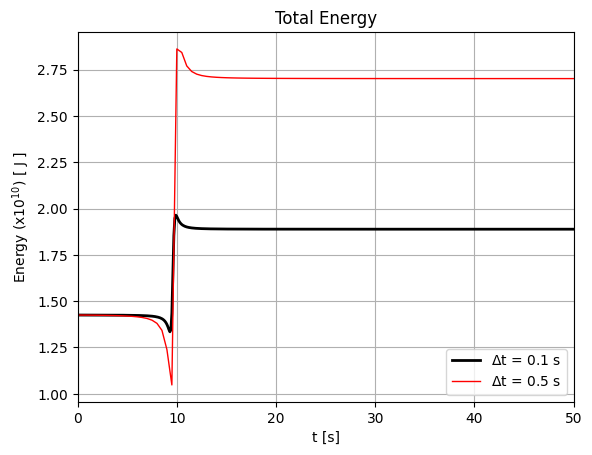

In [10]:
# plot the energy
plt.figure()
plt.title('Total Energy')
plt.plot(time, system_energy, 'black', label='$\Delta$t = 0.1 s', linewidth=2)
plt.plot(time_2, system_energy_2, 'red', label='$\Delta$t = 0.5 s', linewidth=1)
plt.xlabel('t [s]')
plt.ylabel('Energy (x$10^{10}$) [ J ]')
plt.xlim(0, 50)
plt.legend()
plt.grid()

In [11]:
# relative energy error
time_step = np.linspace(0., 1, 50)
energy_error = []

for dt in time_step:
    integrated_pos, integrated_vel, system_energy, time = Euler_integrator(pos.flatten(), vel.flatten(), 1000, 1e-6, dt)
    energy_error.append(np.abs((system_energy[-1] - system_energy[0])/system_energy[0]))

energy_error = np.array(energy_error)

Text(0, 0.5, 'Relative Energy Error')

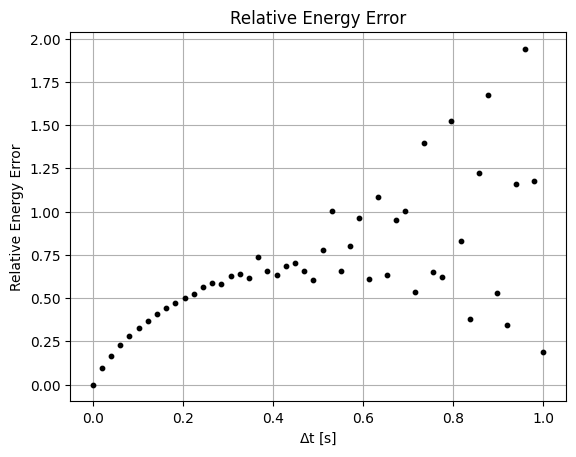

In [12]:
#plot the relative energy error in a scatter plot
plt.figure()
plt.grid()
plt.title('Relative Energy Error')
plt.scatter(time_step, energy_error, color='black', zorder=2, s=10)
plt.xlabel('$\Delta$t [s]')
plt.ylabel('Relative Energy Error')

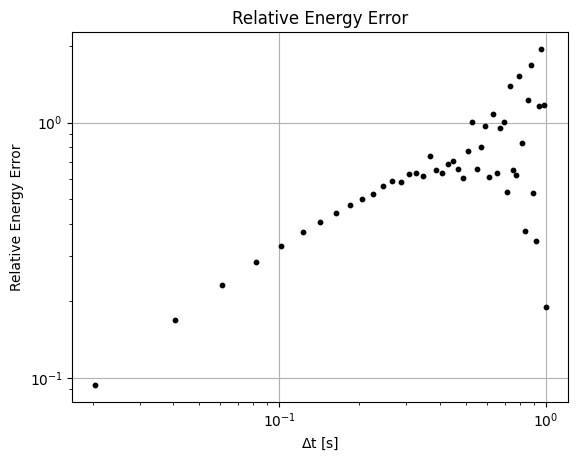

In [13]:
# log-log plot of the relative energy error
plt.figure()
plt.grid()
plt.title('Relative Energy Error')
plt.scatter(time_step, energy_error, color='black', zorder=2, s=10)
plt.xlabel('$\Delta$t [s]')
plt.ylabel('Relative Energy Error')
plt.yscale('log')
plt.xscale('log')
plt.show()

## STABILITY OF PLANETARY SYSTEMS

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from Particle import Particles
from my_RungeKutta4 import integrator_rungekutta

from scipy.integrate import solve_ivp
%matplotlib widget

#IC (N-body)

#mass
M = 1.0                                     #solar mass 2e30 kg
num_planets = 8
m = M*1e-4*np.ones(num_planets)             #mass of the planets

system_masses = np.concatenate(([M], m))  

#distances
orbit_radii = np.linspace(2, 16, num_planets)   # AU
cut_off_distance = 1e-3                         # AU

#simulation time
t0 = 0.0
tf = 2e4                                    #earth years

pos = np.zeros([num_planets+1, 3], float)
for i in range(1, num_planets+1):
    pos[i] = np.array([orbit_radii[i-1], 0., 0.])

vel = np.zeros([num_planets+1, 3], float)
for i in range(1, num_planets+1):
    vel[i] = np.array([0., np.sqrt((M+m[i-1])/orbit_radii[i-1]), 0.])   # minimum velocity for a circular orbit


system = Particles(position=pos, velocity=vel, mass=system_masses)

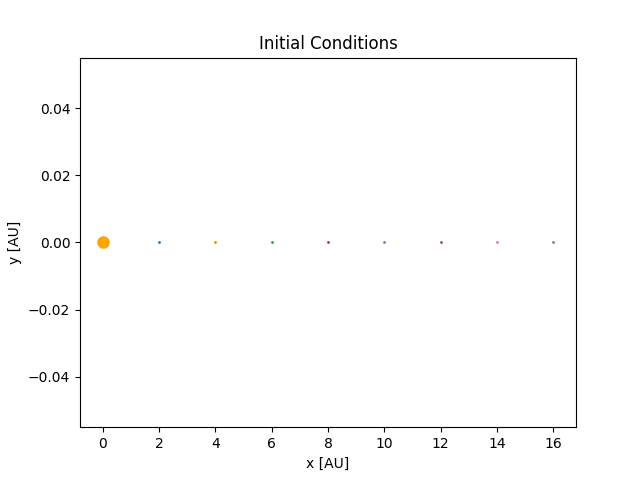

In [15]:
# plot the ic in x-y plane
fig = plt.figure()
plt.plot(system.pos[0, 0], system.pos[0, 1], 'o', markersize=8, color='orange', label='Star')
for i in range(num_planets):
    plt.plot(system.pos[i+1, 0], system.pos[i+1, 1], 'o', markersize=1, label='Planet '+str(i+1))
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Initial Conditions')
#plt.legend()
plt.show()

In [16]:
# Calculate the mean period
T = 2*np.pi*np.sqrt(orbit_radii[num_planets-1]**3 / M)        # period of the last planet 
print('Period of the last planets: ',T,'years')

# time of the simulation
tsimulation = 5*T
print('simulation time: ',tsimulation,'years')

N = int(1e4)                    # number of steps
h = (tsimulation - t0)/N        # time steps

Period of the last planets:  402.1238596594935 years
simulation time:  2010.6192982974676 years


In [17]:
def adaptive_timestep_r(particles, tmin=None, tmax=None):

    #I use the R/V of the particles to have an estimate of the required timestep
    #I don't want the zeros in this procedure
    r  = particles.radius()
    v  = particles.vel_mod()
    ts = r/v
    eta = 0.1             #proportionality constant  
    ts = eta * np.nanmin(ts[np.nonzero(ts)])

    # Check tmin, tmax
    if tmin is not None: ts=np.max(ts,tmin)
    if tmax is not None: ts=np.min(ts,tmax)

    return ts, tmin, tmax

In [18]:
def my_acceleration_simple(part):
    n = part.pos.shape[0]
    acc = np.zeros_like(part.pos)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                denom = np.linalg.norm(part.pos[i] - part.pos[j])**3.
                temp = - part.mass[j]*(part.pos[i] - part.pos[j])/denom
                acc[i,:] = acc[i,:] + temp
            else:
                pass
    
    return acc

In [19]:
def my_acceleration(part):
    n = part.pos.shape[0]
    acc = np.zeros_like(part.pos)
    
    for i in range(n):
        for j in range(n):
            if i != j:
                
                # softened potential
                rij = np.linalg.norm(part.pos[i] - part.pos[j])
                xij = part.pos[i] - part.pos[j]

                if (rij > cut_off_distance):
                    denom = rij**3.
                    temp = - part.mass[j]*(xij)/denom
                    acc[i,:] = acc[i,:] + temp

                else:
                    denom = cut_off_distance**4.
                    temp = part.mass[j]*(-4.*cut_off_distance*xij + 3.*rij*xij)/denom
                    acc[i,:] = acc[i,:] + temp
            else:
                pass
    
    return acc

In [20]:
def integration_rungekutta(part, h, tsimulation, t):
    orbit = []
    velocities = []
    Etot = []
    time = []

    while t < tsimulation and t != tf:      
        updated_part = integrator_rungekutta(particles=part, tstep=h, acceleration_estimator=my_acceleration)
        orbit.append(updated_part.pos)
        velocities.append(updated_part.vel)
        Etot_n, Ekin_n, Epot_n = updated_part.Etot_vett()
        Etot.append(Etot_n)
        
        ts, _, _ = adaptive_timestep_r(part)
        h = ts
        time.append(h)
        t += h

    orbit = np.array(orbit)
    velocities = np.array(velocities)
    Etot = np.array(Etot)
    time = np.array(time)

    return orbit, velocities, Etot, time

In [22]:
system_copy = system.copy()
system_solution, system_velocities, system_energy, system_time = integration_rungekutta(system_copy, h, tsimulation, t0)

(7220, 9, 3)


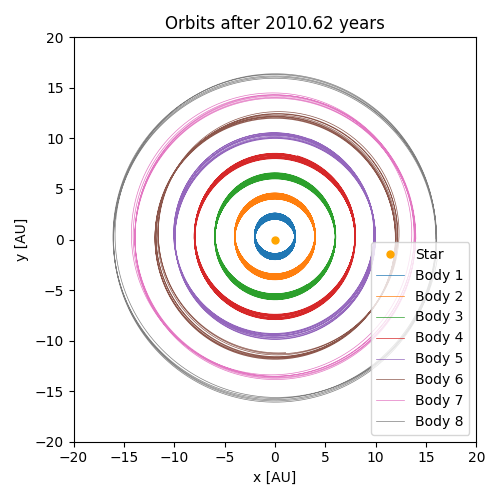

In [23]:
print(system_solution.shape)

# plot the orbit in x-y plane
fig = plt.figure(figsize=(5, 5))
plt.plot(system_solution[0, 0, 0], system_solution[0, 0, 1], 'o', markersize=5, color='orange', label='Star')
for i in range(1, num_planets+1):
    plt.plot(system_solution[:, i, 0], system_solution[:, i, 1], label='Body '+str(i), linewidth=0.5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title(f'Orbits after {tsimulation:.2f} years')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# new time of the simulation
tsimulation = 50*T
print('simulation time: ',tsimulation,'years')

N = int(1e4)                    # number of steps
h = (tsimulation - t0)/N        # time steps

system_copy2 = system.copy()
system_solution2, system_velocities2, system_energy2, system_time2 = integration_rungekutta(system_copy2, h, tsimulation, t0)

simulation time:  20106.192982974677 years


In [35]:
print(system_solution2.shape)
print(system_time2.shape)

(65626, 9, 3)
(65626,)


In [45]:
# calculate distances from the center
N = system_solution2.shape[0]
dist = np.zeros([N, num_planets], float)

for i in range(N):
    dist[i] = np.linalg.norm(system_solution2[i, 1:, :], axis=1)

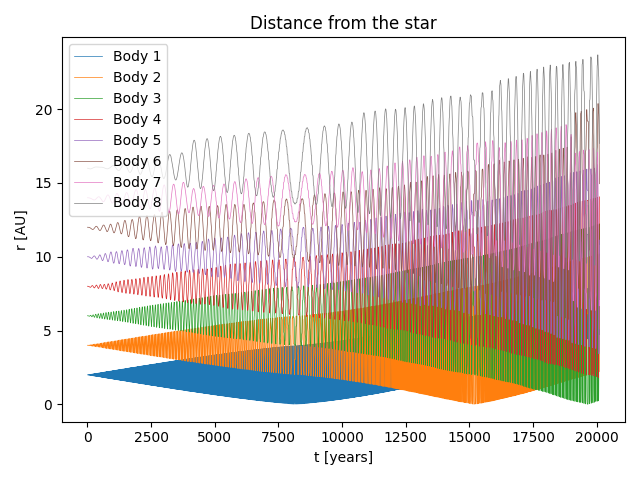

In [48]:
# plot the distances from the center
t_span = np.linspace(0, tsimulation, N)

fig = plt.figure()
for i in range(num_planets):
    plt.plot(t_span, dist[:, i], label='Body '+str(i+1), linewidth=0.5)
plt.xlabel('t [years]')
plt.ylabel('r [AU]')
plt.title('Distance from the star')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
'''
# Total angular momentum
L = np.zeros([N, num_planets+1, 3], float)
for i in range(N):
    L[i] = np.sum(np.cross(system_solution2[i], system_velocities2[i]*system_masses))
'''